# Linear Classification with Hinge-Loss

In this exercise, you will implement and train a linear classifier using hinge loss.

Please complete all cells and answer questions asked in the cells if you want to get a full grade.


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading the MNIST Dataset

MNIST (http://yann.lecun.com/exdb/mnist/) is one of the popular datasets used for testing machine learning models. It contains hand-written digits as grayscale images with 28x28 resolution. There are 60,000 samples for training (10,000 of which is usually used for validation), and 10,000 for testing. Although there are more challenging datasets available, MNIST is a good starting point for testing early versions of the models and as a sanity check.

Since more challenging datasets require more memory and lead to bigger models that require more computational power, we will stick with the MNIST dataset for the first HW.

In [2]:
# First run the "get_data.sh" under metu/data/ in your terminal.
# Then this cell will load the raw MNIST data.
#
#
from ceng783.utils import load_mnist
mnist_file = 'ceng783/data/mnist.pkl.gz'
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(mnist_file)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 784)
Training labels shape:  (50000,)
Validation data shape:  (10000, 784)
Validation labels shape:  (10000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


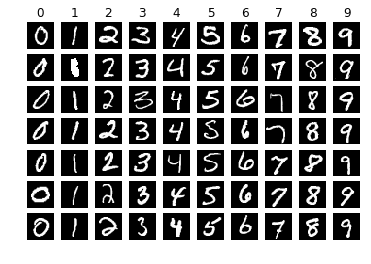

In [3]:
# Visualize some examples from the dataset.
# 
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        #plt.imshow(X_train[idx].astype('uint8'))
        img_2d = np.reshape(X_train[idx], (28, 28))
        plt.imshow(img_2d, cmap=plt.get_cmap('gray'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for faster experiments in this exercise.
num_training = 10000
num_validation = 1000
num_test = 1000

X_train = X_train[1:num_training]
y_train = y_train[1:num_training]

X_val = X_val[1:num_validation]
y_val = y_val[1:num_validation]

X_test = X_test[1:num_test]
y_test = y_test[1:num_test]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (9999, 784)
Train labels shape:  (9999,)
Validation data shape:  (999, 784)
Validation labels shape:  (999,)
Test data shape:  (999, 784)
Test labels shape:  (999,)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


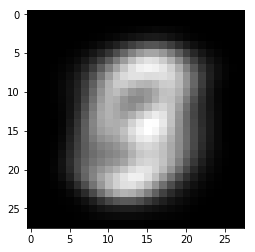

In [5]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((28,28))) # visualize the mean image

In [6]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

In [7]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# Also, lets transform both data matrices so that each image is a column.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape

(9999, 785) (999, 785) (999, 785)


## Linear Classifier with Hinge Loss
Your code for this section will all be written inside **ceng783/linear_classification.py**. 

As you can see, we have prefilled the function `naive_hinge_loss` which uses for loops to evaluate the multiclass hinge loss.

In [39]:
# Evaluate the naive implementation of the loss we provided for you:
from ceng783.linear_classification import *

input_size = X_train[0].shape[0]
output_size = 10

LC = LinearClassifier(input_size, output_size) # initializes the weights to random small numbers

loss, grad = LC.naive_hinge_loss(X_train, y_train, delta=1)

print 'loss: %f' % (loss, )

loss: 8.998597


In [18]:
grad

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -3.60506051],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -4.18471847],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -3.55905591],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -3.92249225],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -3.34283428],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -3.49924992]])

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the hinge-loss function and implement it inline inside the function `naive_hinge_loss`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [149]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

W = 1e-4 * np.random.randn(output_size, input_size)

# Compute the loss and its gradient at W.
loss, grad = LC.naive_hinge_loss(X_train, y_train, W=W, reg=0.0, delta=1)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from ceng783.utils import grad_check_sparse
f = lambda w: LC.naive_hinge_loss(X_train, y_train, W=w, reg=0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# You should see differences on the order of 10^-7, 10^-8

numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.033250 analytic: 0.033250, relative error: 8.619427e-09
numerical: 0.178145 analytic: 0.178145, relative error: 1.071111e-08
numerical: 0.006097 analytic: 0.006097, relative error: 1.087891e-07
numerical: 0.008820 analytic: 0.008820, relative error: 1.633995e-07
numerical: -0.204721 analytic: -0.204721, relative error: 1.535728e-09
numerical: -0.001414 analytic: -0.001414, relative error: 2.787463e-07
numerical: 0.028937 analytic: 0.028937, relative error: 7.446479e-08
numerical: 0.002641 analytic: 0.002641, relative error: 2.213314e-08
numerical: -0.299087 analytic: -0.299087, relative error: 3.957702e-09


In [160]:
# Next implement the function vectorized_hinge_loss; for now only compute the loss;
# we will implement the gradient in a moment.
import time
tic = time.time()
loss_naive, grad_naive = LC.naive_hinge_loss(X_train, y_train, W=W)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

tic = time.time()
loss_vectorized, _ = LC.vectorized_hinge_loss(X_train, y_train, W=W)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)
# You should get zero difference

Naive loss: 9.001197e+00 computed in 0.346339s
Vectorized loss: 9.001217e+00 computed in 0.037568s
difference: -0.000020


In [161]:
# Complete the implementation of vectorized_hinge_loss, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = LC.naive_hinge_loss(X_train, y_train, W=W)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = LC.vectorized_hinge_loss(X_train, y_train, W=W)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.353188s
Vectorized loss and gradient: computed in 0.037592s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [170]:
# Now implement SGD in LinearClassifier.train() function and run it with the code below
tic = time.time()

LC = LinearClassifier(input_size, output_size)

stats = LC.train(X_train, y_train, X_val, y_val, learning_rate=0.001, reg=0.0001, delta=1,
                      num_iters=1500, batch_size=32, loss='hinge', verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)


iteration 0 / 1500: loss 9.000542
iteration 100 / 1500: loss 2.481584
iteration 200 / 1500: loss 2.141481
iteration 300 / 1500: loss 1.438740
iteration 400 / 1500: loss 2.110325
iteration 500 / 1500: loss 2.257268
iteration 600 / 1500: loss 1.040217
iteration 700 / 1500: loss 1.249023
iteration 800 / 1500: loss 1.251741
iteration 900 / 1500: loss 1.629283
iteration 1000 / 1500: loss 1.456539
iteration 1100 / 1500: loss 1.377396
iteration 1200 / 1500: loss 1.484134
iteration 1300 / 1500: loss 2.034785
iteration 1400 / 1500: loss 1.367603
That took 0.846252s


Text(0,0.5,'Loss value')

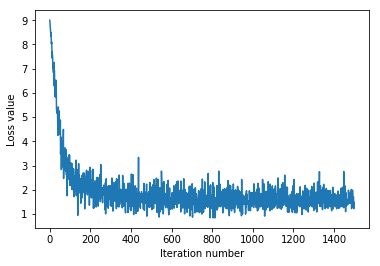

In [164]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(stats['loss_history'])
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [171]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = LC.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = LC.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.884288
validation accuracy: 0.865866


In [166]:
# Use the validation set to tune hyperparameters (delta, regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-3, 1e-7, 5e-5]
regularization_strengths = [5e-3, 1e-5]
delta_ranges = [1, 2, 3]
# results is dictionary mapping tuples of the form
# (delta, learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_LC = None # The LinearClassifier object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear Classifier on   #
# the training set, compute its accuracy on the training and validation sets,  #
# and store these numbers in the results dictionary. In addition, store the    #
# best validation accuracy in best_val and the LinearClassifier object that    #
# achieves this accuracy in best_svm.                                          #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the models don't take much time to train; once you   #
# are confident that your validation code works, you should rerun the          #
# validation  code with a larger value for num_iters.                          #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        for dr in delta_ranges:
                LC = LinearClassifier(input_size, output_size)
                LC.train(X_train, y_train, X_val, y_val, learning_rate=lr, reg=rs, delta=dr,
                          num_iters=1500, batch_size=32, loss='hinge', verbose=False)
                y_train_pred = LC.predict(X_train)
                y_val_pred = LC.predict(X_val)

                train_acc = np.mean(y_train == y_train_pred)
                val_acc = np.mean(y_val == y_val_pred)

                if (val_acc>best_val):
                    best_LC = LC
                    best_val = val_acc

                results[(lr,rs,dr)] = train_acc , val_acc

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for delta, lr, reg, in sorted(results):
    train_accuracy, val_accuracy = results[(delta, lr, reg)]
    print 'delta %d lr %e reg %e train_acc: %f val_acc: %f' % (
                delta, lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

delta 0 lr 1.000000e-05 reg 1.000000e+00 train_acc: 0.546255 val_acc: 0.521522
delta 0 lr 1.000000e-05 reg 2.000000e+00 train_acc: 0.553355 val_acc: 0.523524
delta 0 lr 1.000000e-05 reg 3.000000e+00 train_acc: 0.533953 val_acc: 0.525526
delta 0 lr 5.000000e-03 reg 1.000000e+00 train_acc: 0.549455 val_acc: 0.522523
delta 0 lr 5.000000e-03 reg 2.000000e+00 train_acc: 0.557356 val_acc: 0.531532
delta 0 lr 5.000000e-03 reg 3.000000e+00 train_acc: 0.552855 val_acc: 0.562563
delta 0 lr 1.000000e-05 reg 1.000000e+00 train_acc: 0.758376 val_acc: 0.728729
delta 0 lr 1.000000e-05 reg 2.000000e+00 train_acc: 0.722472 val_acc: 0.694695
delta 0 lr 1.000000e-05 reg 3.000000e+00 train_acc: 0.724272 val_acc: 0.696697
delta 0 lr 5.000000e-03 reg 1.000000e+00 train_acc: 0.757376 val_acc: 0.732733
delta 0 lr 5.000000e-03 reg 2.000000e+00 train_acc: 0.723272 val_acc: 0.692693
delta 0 lr 5.000000e-03 reg 3.000000e+00 train_acc: 0.720772 val_acc: 0.695696
delta 0 lr 1.000000e-05 reg 1.000000e+00 train_acc: 

Text(0.5,1,'MNIST validation accuracy')

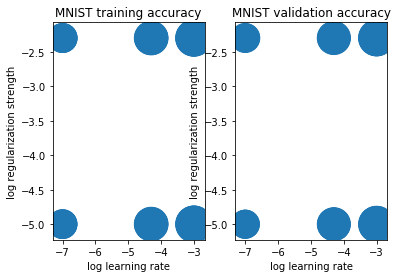

In [167]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
sz = [results[x][0]*1500 for x in results] # default size of markers is 20
plt.subplot(1,2,1)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('MNIST training accuracy')

# plot validation accuracy
sz = [results[x][1]*1500 for x in results] # default size of markers is 20
plt.subplot(1,2,2)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('MNIST validation accuracy')

In [168]:
# Evaluate the best model on test set
y_test_pred = best_LC.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear classifier on raw pixels final test set accuracy: %f' % test_accuracy

linear classifier on raw pixels final test set accuracy: 0.860861


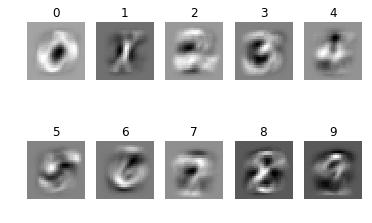

In [169]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_LC.params['W'][:,:-1] # strip out the bias
w = w.reshape(10, 28, 28)
w_min, w_max = np.min(w), np.max(w)
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized Linear Classifier weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *They look like the classes they are representing. Because they try to maximize the output of their class when the input looks like them. An images pixels will be multiplied by weights we see above and creates scores; look how the pixels in the middle punishes the score of '0'. Also weights corresponding to zero-like pattern contributes to score highly when the pixel is bright.*